# Cropper?

Task:
- function for determining if an image has circular dark areas
- function to crop into a square around the non-dark areas
- put it altogether in a neat function that can be applied during preprocessing

Example in [this paper](https://methods-x.com/article/S2215-0161(20)30083-2/fulltexthttps://methods-x.com/article/S2215-0161(20)30083-2/fulltext):
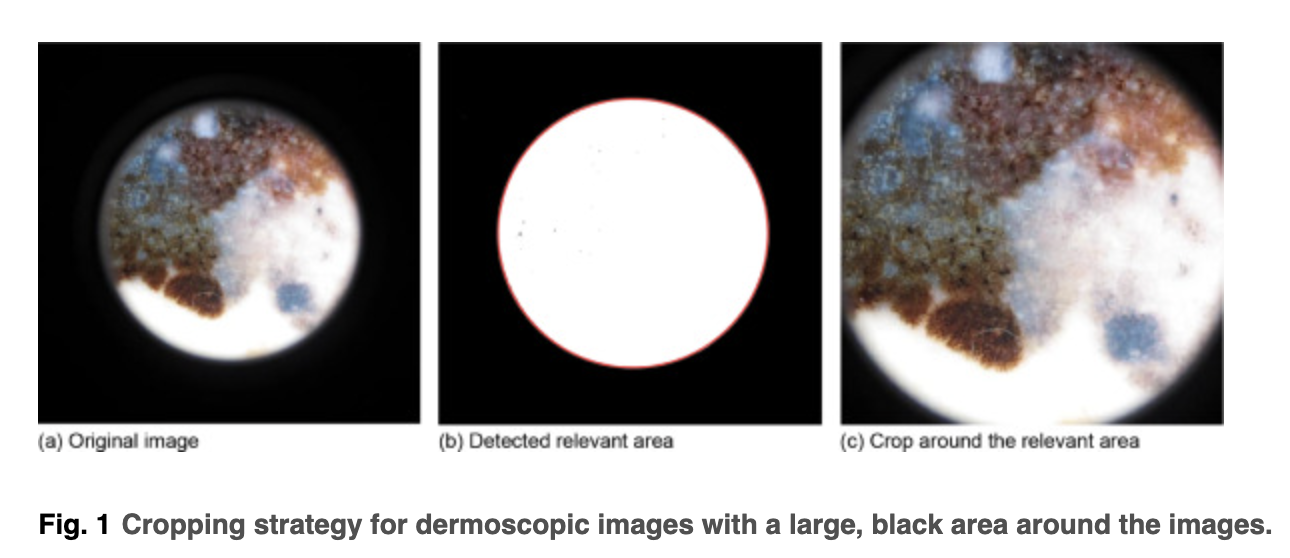

In [ ]:
!pip install tensorflow-addons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

import data
import utils

2022-11-09 07:16:18.465414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


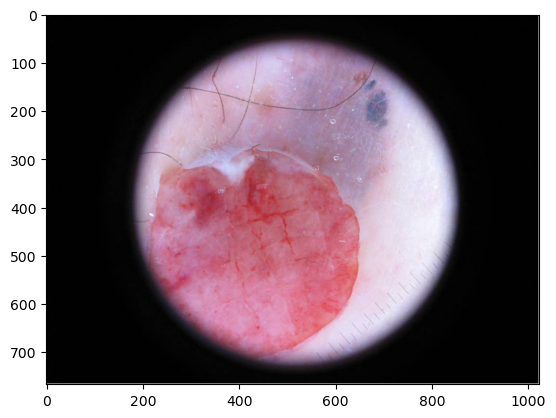

In [105]:
# Example image with border
imagefile = utils.get_image_by_id("ISIC_0000004")
utils.plot_image_by_id("ISIC_0000004")

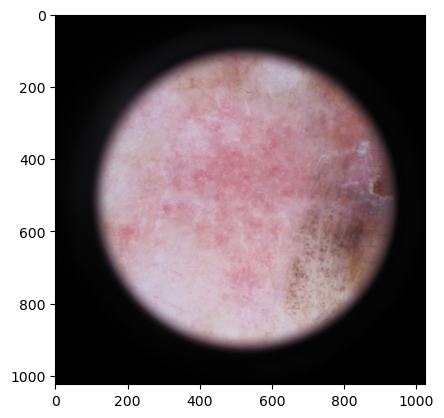

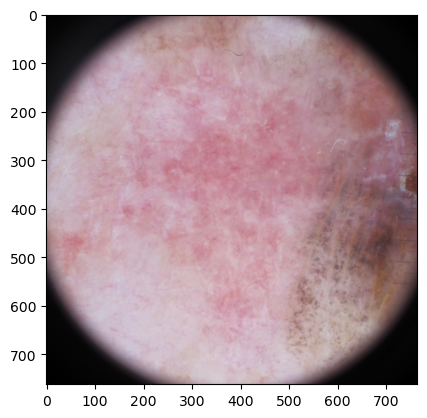

In [103]:
# Using another image for validating functions
img_name = "ISIC_0055771"
imagefile = utils.get_image_by_id(img_name)
utils.plot_image_by_id(img_name);
plt.figure()
plt.imshow(crop_image(imagefile));

## Detection

Does it have black circle/borders?

I imagine splitting an image into two types of regions: inner and outer section, then getting the mean of pixels, and then getting a difference on that. A calculated difference above a certain threshold will be marked as having black circles.

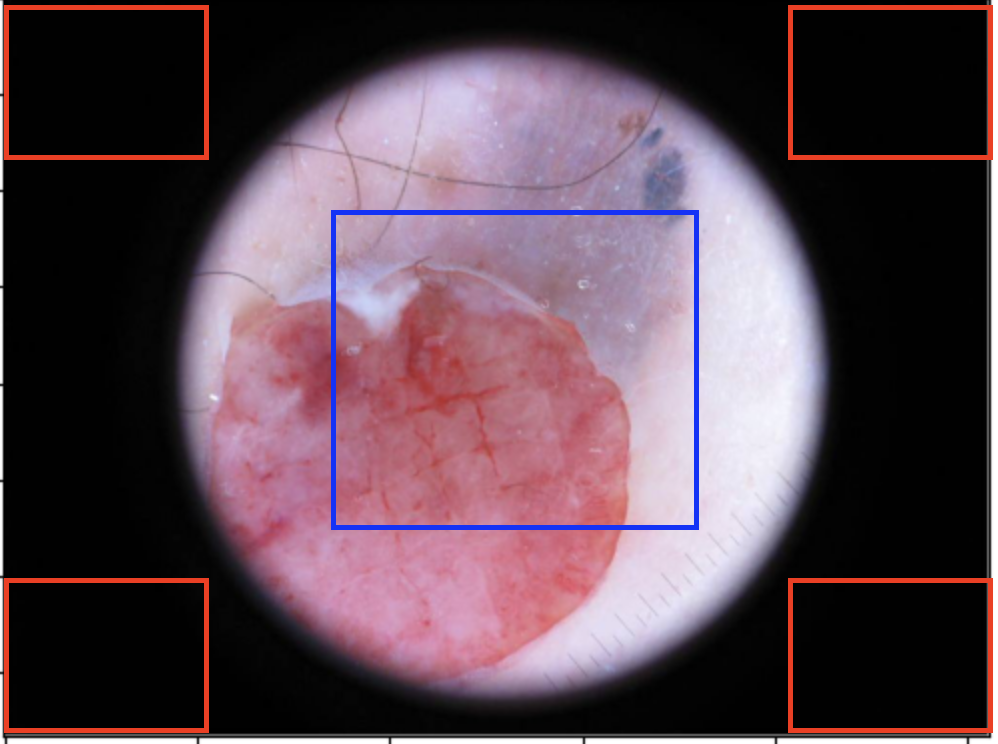

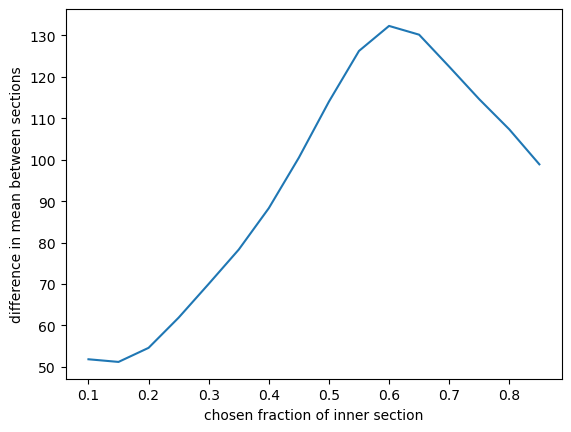

In [46]:
# Use average then figure out the difference
# split into 9 rectangles, then compare inner rectangle vs the rest

fraction_results = {}
for inner_fraction in np.arange(0.1, 0.9, 0.05):
    shape = imagefile.shape
    inner_start = (1 - inner_fraction) / 2
    inner_end = 1 - inner_start

    inner_section = imagefile[
        int(shape[0] * inner_start): int(shape[0] * inner_end),
        int(shape[1] * inner_start): int(shape[1] * inner_end),
        :
    ]
    inner_mean = inner_section.mean()
    outer_mean = (imagefile.sum() - inner_section.sum()) / (np.product(shape) - np.product(inner_section.shape))
    fraction_results[inner_fraction] = inner_mean - outer_mean
    
plt.plot(fraction_results.keys(), fraction_results.values())
plt.xlabel("chosen fraction of inner section")
plt.ylabel("difference in mean between sections");

Inner section fraction of 0.6 gives the biggest difference. Let's use that.

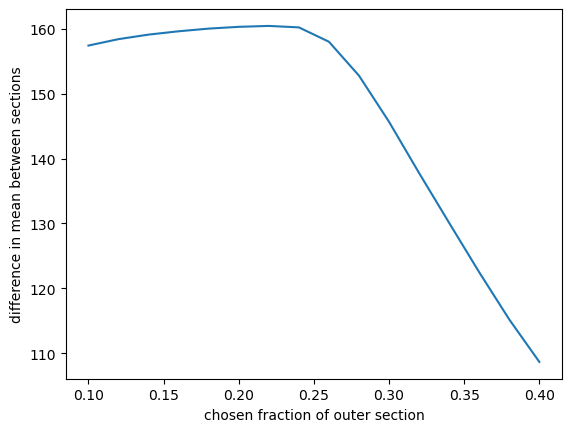

In [47]:
# Could also do the same for outer section

fraction_results = {}
for outer_fraction in np.arange(0.1, 0.4, 0.02):
    shape = imagefile.shape
    inner_fraction = 0.6
    inner_start = (1 - inner_fraction) / 2
    inner_end = 1 - inner_start

    inner_section = imagefile[
        int(shape[0] * inner_start): int(shape[0] * inner_end),
        int(shape[1] * inner_start): int(shape[1] * inner_end),
        :
    ]
    
    outer_section_shape = int(shape[0] * outer_fraction), int(shape[1] * outer_fraction)
    outer_sections = [
        imagefile[:outer_section_shape[0], :outer_section_shape[1], :],
        imagefile[-outer_section_shape[0]:, :outer_section_shape[1], :],
        imagefile[:outer_section_shape[0], -outer_section_shape[1]:, :],
        imagefile[-outer_section_shape[0]:, -outer_section_shape[1]:, :],
    ]
    inner_mean = inner_section.mean()
    outer_mean = np.mean([section.mean() for section in outer_sections])
    fraction_results[outer_fraction] = inner_mean - outer_mean
    
plt.plot(fraction_results.keys(), fraction_results.values())
plt.xlabel("chosen fraction of outer section")
plt.ylabel("difference in mean between sections");


Outer section fraction could be risky going towards the right, but doesn't have much loss when choosing a small fraction. Let's use 0.2 as our outer fraction.

In [3]:
def has_black_circle(imagefile, diff_threshold=90):
    """Detector for if a black circle exists in image.
    
    Use average then figure out the difference
    
    Split into 9 rectangles, then compare inner rectangle vs the rest.
    
    diff_threshold: if difference in mean is greater than this number, mark as positive."""

    shape = imagefile.shape
    inner_fraction = 0.60
    outer_fraction = 0.20
    inner_start = (1 - inner_fraction) / 2
    inner_end = 1 - inner_start

    inner_section = imagefile[
        int(shape[0] * inner_start): int(shape[0] * inner_end),
        int(shape[1] * inner_start): int(shape[1] * inner_end),
        :
    ]
    outer_section_shape = int(shape[0] * outer_fraction), int(shape[1] * outer_fraction)
    outer_sections = [
        imagefile[:outer_section_shape[0], :outer_section_shape[1], :],
        imagefile[-outer_section_shape[0]:, :outer_section_shape[1], :],
        imagefile[:outer_section_shape[0], -outer_section_shape[1]:, :],
        imagefile[-outer_section_shape[0]:, -outer_section_shape[1]:, :],
    ]
    
    inner_mean = inner_section.mean()
    outer_mean = np.mean([section.mean() for section in outer_sections])
    diff = inner_mean - outer_mean
    return diff >= diff_threshold
    
has_black_circle(imagefile)

True

In [4]:
data.metadata_train[data.metadata_train["image"]=="ISIC_0054869"].index

Int64Index([13782], dtype='int64')

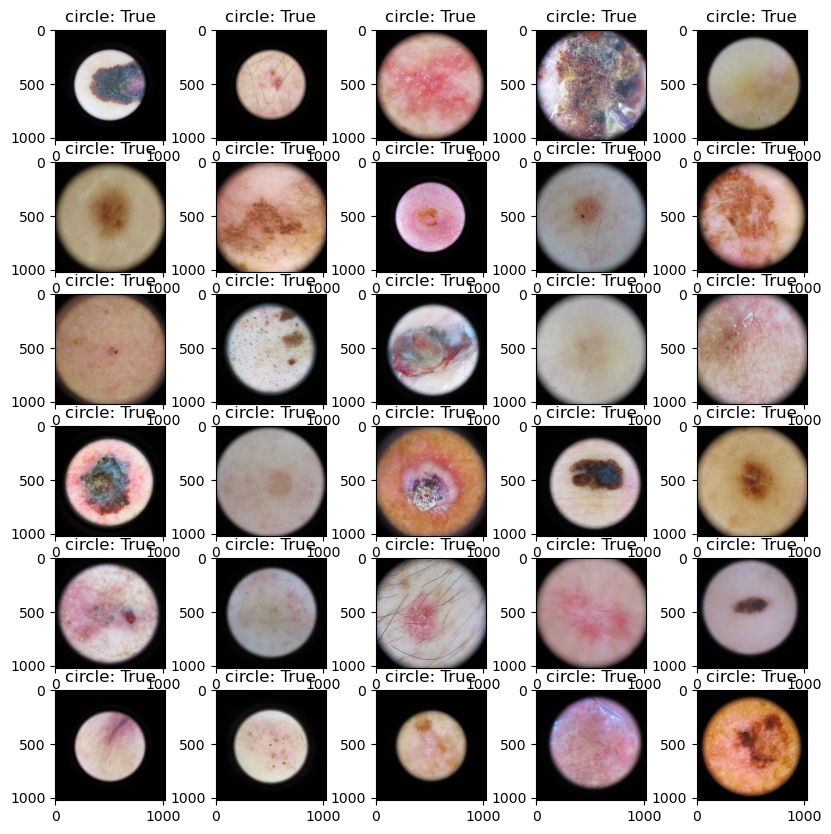

In [7]:
# Test on multiple other images
plt.figure(figsize=(10, 10))
total_to_test = 30
idx = 13782
n = 1
while n <= total_to_test:
    idx += 1
    img_name = data.metadata_train.loc[idx, "image"]
    try:
        img = utils.get_image_by_id(img_name)
    except:
        
        continue
    res = has_black_circle(img)
    if not res:
        continue
    plt.subplot(int(np.ceil(total_to_test/5)), 5, n)
    plt.imshow(img)
    plt.title(f"circle: {res}")
    n += 1
    

## Cropping

Knowing it has black borders, how to choose where to crop?

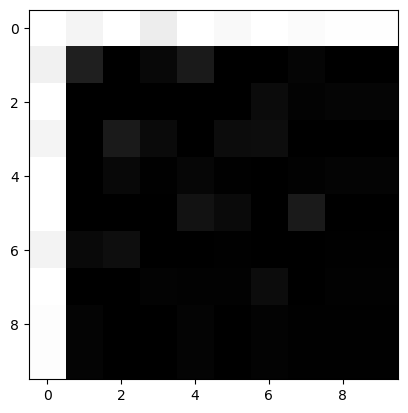

In [57]:
# first have to slice off a couple pixels off the border; here's why
# Showing the upper left 10x10 corner
plt.imshow(imagefile[0:10, 0:10, :]);

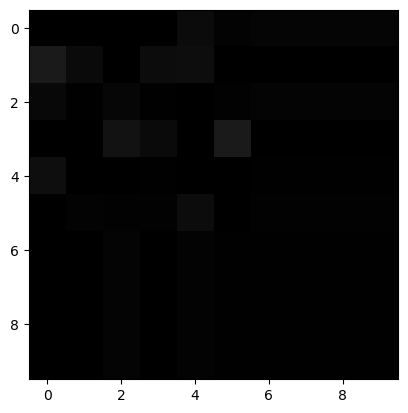

In [58]:
# slicing:
sliced_imagefile = imagefile[2:-2, 2:-2, :]
plt.imshow(sliced_imagefile[0:10, 0:10, :]);  # upper left corner is now good

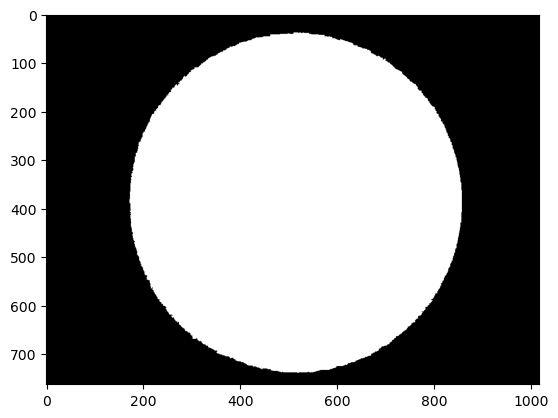

In [59]:
# investigate slices and thresholds
dark_threshold = 20  # anything below this value is "black"
dark_mask = (sliced_imagefile[:,:,0] <= dark_threshold).astype(int)
plt.imshow(dark_mask, vmin=0, vmax=1, cmap='gray_r');

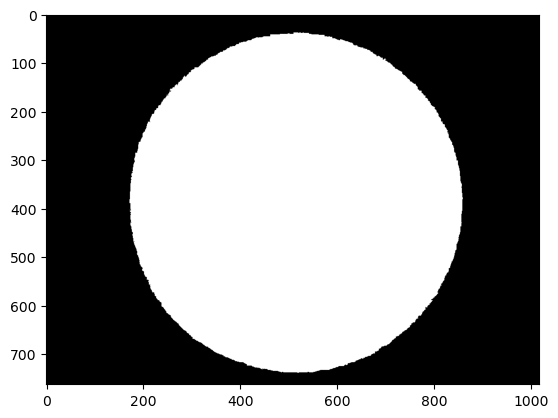

In [60]:
# Apply to all 3 RGB?
dark_threshold = 20  # anything below this value is "black"
dark_mask = np.all(sliced_imagefile <= dark_threshold, axis=2)
plt.imshow(dark_mask, vmin=0, vmax=1, cmap='gray_r');

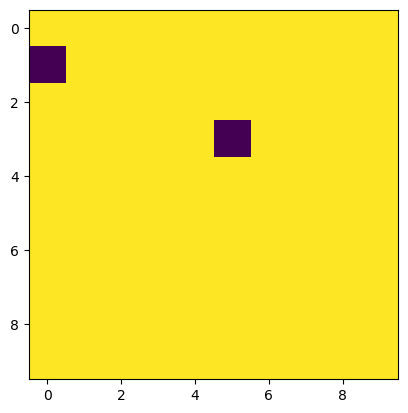

In [61]:
# plotting first 10x10 upper-left corner -- turns out there's a lot of noise!!
plt.imshow(dark_mask[0:10, 0:10]);

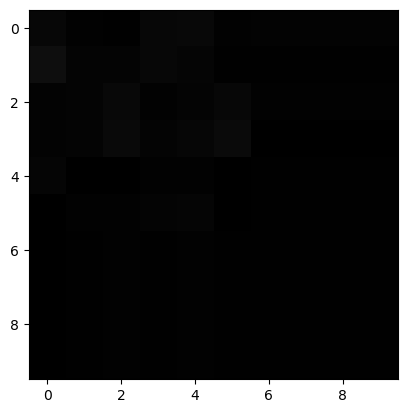

In [62]:
# Another strategy -- get neighboring pixels? like CNN filter
blurred_imagefile = tfa.image.gaussian_filter2d(sliced_imagefile, filter_shape=(2, 2))
plt.imshow(blurred_imagefile[0:10, 0:10, :]);

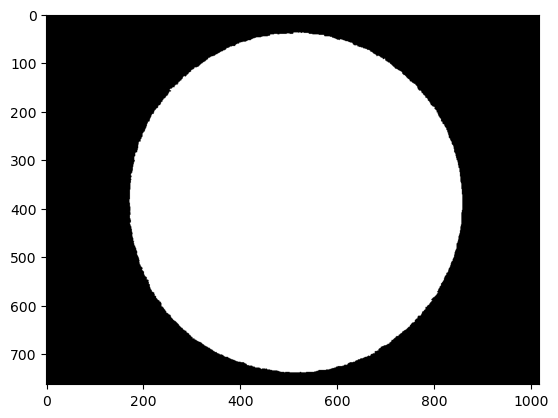

In [63]:
# Repeat thresholding above
dark_threshold = 20  # anything below this value is "black"
dark_mask = np.all(blurred_imagefile <= dark_threshold, axis=2)
plt.imshow(dark_mask, vmin=0, vmax=1, cmap='gray_r');

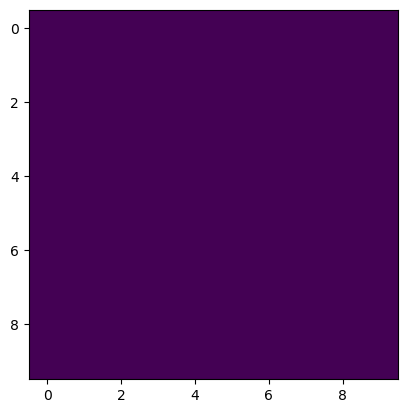

In [64]:
# plotting first 10x10 upper-left corner again -- much better
plt.imshow(dark_mask[0:10, 0:10]);

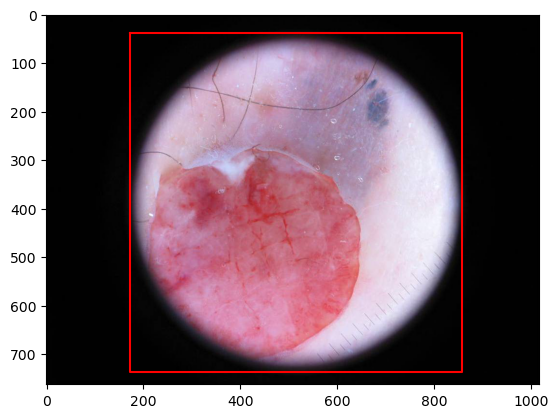

In [65]:
# getting 4 corners 
light_pixels = np.argwhere(dark_mask==False)
box = (
    (
        light_pixels[:, 0].min(),  # top-most
        light_pixels[:, 0].max(),  # bottom-most
    ),
    (
        light_pixels[:, 1].min(),  # left-most
        light_pixels[:, 1].max(),  # right-most
    )
)

plt.imshow(sliced_imagefile)
plt.plot(
    [
        box[1][0],
        box[1][0],
        box[1][1],
        box[1][1],
        box[1][0],
    ],
    [
        box[0][0],
        box[0][1],
        box[0][1],
        box[0][0],
        box[0][0],
    ],
    '-r',
);

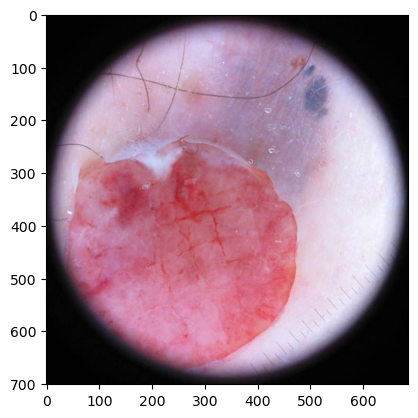

In [66]:
# Cropping it
cropped_imagefile = sliced_imagefile[
    box[0][0]:box[0][1]+1,
    box[1][0]:box[1][1]+1,
    :
]
plt.imshow(cropped_imagefile);

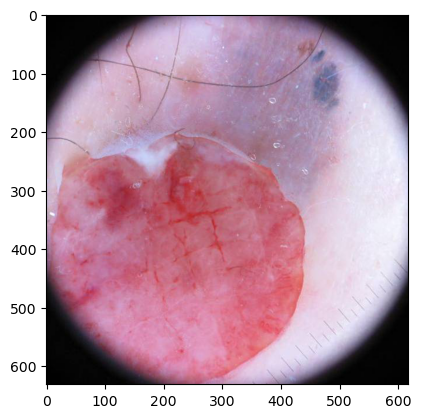

In [67]:
# Finally, let's get rid of some additional bits to get really close to what we need
trim_fraction = 0.02  # trim additional 2 percent from each edge
trim_height, trim_width, _ = [s * 0.05 for s in cropped_imagefile.shape]
trim_height = int(trim_height)
trim_width = int(trim_width)

trimmed_imagefile = cropped_imagefile[
    trim_height:-trim_height,
    trim_width:-trim_width,
    :
]
plt.imshow(trimmed_imagefile);

In [116]:
# putting it altogether
def crop_image(imagefile):
    if not has_black_circle(imagefile):
        return imagefile
    
    sliced_imagefile = imagefile[2:-2, 2:-2, :]
    blurred_imagefile = tfa.image.gaussian_filter2d(sliced_imagefile, filter_shape=(2, 2))
    
    dark_threshold = 20  # anything below this value is "black"
    dark_mask = np.all(blurred_imagefile <= dark_threshold, axis=2)
    
    light_pixels = np.argwhere(dark_mask==False)
    box = (
        (
            light_pixels[:, 0].min(),  # top-most
            light_pixels[:, 0].max(),  # bottom-most
        ),
        (
            light_pixels[:, 1].min(),  # left-most
            light_pixels[:, 1].max(),  # right-most
        )
    )
    cropped_imagefile = sliced_imagefile[
        box[0][0]:box[0][1]+1,
        box[1][0]:box[1][1]+1,
        :
    ]
    
    trim_fraction = 0.02  # trim additional 2 percent from each edge
    trim_height, trim_width, _ = [s * 0.05 for s in cropped_imagefile.shape]
    trim_height = int(trim_height)
    trim_width = int(trim_width)

    trimmed_imagefile = cropped_imagefile[
        trim_height:-trim_height,
        trim_width:-trim_width,
        :
    ]
    return trimmed_imagefile

In [117]:
# computation time?
%time c_img = crop_image(imagefile)

CPU times: user 554 ms, sys: 3.99 ms, total: 558 ms
Wall time: 295 ms


In [100]:
# What about an image with no black circle?
%time c_img = crop_image(imagefile)

CPU times: user 43.3 ms, sys: 992 µs, total: 44.3 ms
Wall time: 39.5 ms


Estimated time to process the entire dataset (without considering loading or saving times, and on my personal laptop):
- 6226 with black circles: 6226 * ~600 ms = **1.04 h**
- 19105 with no black circles: 19105 * ~46 ms = 0.24 h

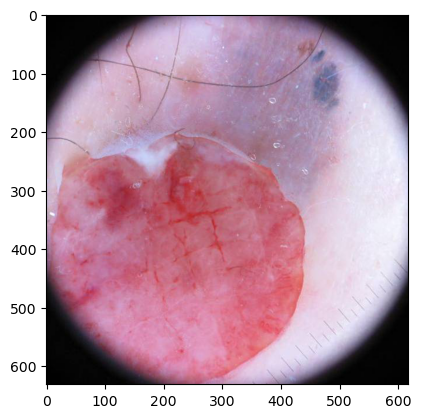

In [118]:
plt.imshow(c_img);

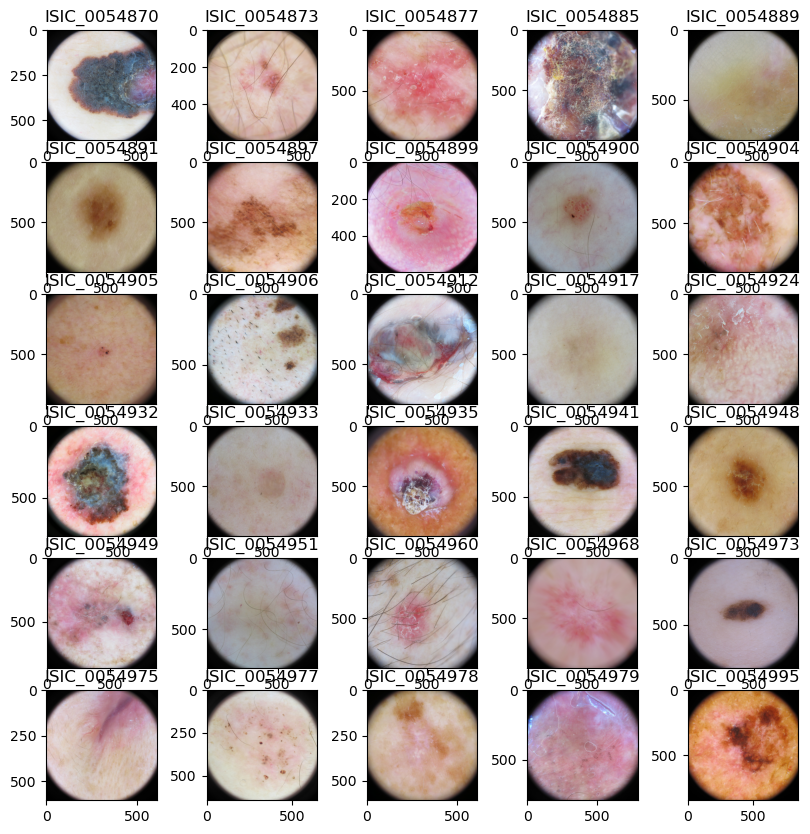

In [101]:
# Test multiple
plt.figure(figsize=(10, 10))
total_to_test = 30
idx = 13782
n = 1
while n <= total_to_test:
    idx += 1
    img_name = data.metadata_train.loc[idx, "image"]
    try:
        img = utils.get_image_by_id(img_name)
    except:
        
        continue
    res = has_black_circle(img)
    if not res:
        continue
    plt.subplot(int(np.ceil(total_to_test/5)), 5, n)
    plt.imshow(crop_image(img))
    plt.title(img_name)
    n += 1
    